* pixels centers: $(x_i,y_i) \in [-1,1]$ with $x_i = -1 + (i+1/2) \cdot h$, $h = 2/n$, $i=0, \ldots, n-1$
* detector element centers: $s_i \in [-2\sqrt{2}, 2\sqrt{2}]$ determined via

get symmetric grid with $m$ points of $[-L,L]$ $x_i = x_{-1} +  i \cdot h$ with $h$ fixed and $m$, $x_{-1}$, to be determined.

We need $x_{m-1} = -x_{0}$ so $-x_{-1} = x_{-1} + (m-1)h$ so $x_{-1} = (1-m)h/2$ and $m$ chosen such that $x_{-1}\approx -L$, so $|L + (1-m)h/2|$ minimal. $|2L + h - mh|$ minimal, $m = (2L + h)/h = 2L/h + 1$

Note that we like $m$ to have the same parity as $n$.

X-ray with angle $\theta$ and offset $s$:

$$ x = t \sin\theta + s \cos\theta, y = -t\cos\theta + s\sin\theta $$

now for fixed $(s,\theta)$ determine intersections with grid lines ${-1, -1+h, -1+2h, \ldots, -1+nh}$, call these $x_i, y_i$:

$$t = (x_i - s \cos\theta)/\sin \theta$$

$$t = -(y_i - s \sin\theta)/\cos \theta$$

$x\cos\theta = t\sin\theta\cos\theta + s \cos^2\theta, y\sin\theta = -t\cos\theta\sin\theta + s\sin^2\theta$

$$x\cos\theta + y\sin\theta = s$$

In [54]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from time import perf_counter

In [55]:
def ray(n, s,theta):
    """
    Trace ray:
        x(t) =  t*sin(theta) + s*cos(theta)
        y(t) = -t*cos(theta) + s*sin(theta)
    through volume [-1,1]^2, discretised with n x n pixels.
    
    Returns linear indices of intersected pixels and corresponding intersection lengths
    """
    
    # define boundaries of pixels
    h = 2/n
    x = -1 + np.linspace(0,n,n+1)*h
    y = -1 + np.linspace(0,n,n+1)*h
    
    # compute all intersections with horizontal and vertical grid lines
    # in terms of path length parameter t
    t = []
    if np.abs(np.sin(theta)) > 0:
        tx = (x - s*np.cos(theta))/np.sin(theta)
        t = np.concatenate((t,tx))
    if np.abs(np.cos(theta)) > 0 :
        ty = -(y - s*np.sin(theta))/np.cos(theta)
        t = np.concatenate((t,ty))
    
    # sort t in increasing order
    t = np.sort(t[np.isfinite(t)])
    
    # now trace the ray and store pixel-indices and path lengths
    nt = len(t)
    I = []
    w = []
    for i in range(nt-1):
        # entry point of ray
        x1 = t[i]*np.sin(theta) + s*np.cos(theta)
        y1 = -t[i]*np.cos(theta) + s*np.sin(theta)
        
        # exit point of ray
        x2 = t[i+1]*np.sin(theta) + s*np.cos(theta)
        y2 = -t[i+1]*np.cos(theta) + s*np.sin(theta)
        
        # pixel indices
        ix = int(((x1 + x2)/2+1)//h)
        iy = int(((y1 + y2)/2+1)//h)
        
        # only take pixels in volume [-1,1]^2 in to account
        if (0 <= ix < n) and (0 <= iy < n):
            I.append(int(iy*n + ix))
            w.append(t[i+1] - t[i])
        
    return I,w

In [56]:
def get_matrix(n, vs,vtheta):
    """
    Fill (dense) matrix for given grid, detector and angles.
    """
    ns = len(vs)
    nt = len(vtheta)
    
    A = np.zeros((ns*nt,n**2))
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, vs[j],vtheta[i])
            A[i*ns + j,J] = w
    return A

In [76]:
def get_sparse_matrix(n, vs,vtheta):
    """
    Fill (sparse) matrix for given grid, detector and angles.
    """
    ns = len(vs)
    nt = len(vtheta)
    
    I = []
    J = []
    W = []
    for i in range(nt):
        for j in range(ns):
            Jij,w = ray(n, vs[j],vtheta[i])
            I = np.concatenate((I,len(Jij)*[i*ns + j]))
            J = np.concatenate((J,Jij))
            W = np.concatenate((W,w))
    return coo_matrix((W, (I, J)), shape=(ns*nt,n**2))

In [93]:
def Radon(n):
    """
    Define fully sampled Radon transform with grid-spacing n. The detector has same gridspacing as volume, 
    and spans [-sqrt(2),sqrt(2)], the n angles are  equispaced in [0,2pi].
    
    This produces a matrix of size m*n x n*n with m = int((2*L/h + 1))
    """
    # volume grid
    h = 2/n
    x = -1 + h/2 + np.linspace(0,n-1,n)*h
    
    # detector grid, take care to make it symmetric and include 0 when n is odd.
    L = np.sqrt(2)
    m = int((2*L/h + 1))
    if (n%2) != (m%2):
        m += 1 
    s = (1-m)*h/2 + np.linspace(0,m-1,m)*h
    
    # angular grid
    theta = np.linspace(0,2*np.pi,n)
    
    # get matrix
    A = get_matrix(n, s,theta)
    
    return A, x, s, theta

In [124]:
def Radon_forward(n,u):
    """
    Matrix-free matvec with Radon
    """
    # volume grid
    h = 2/n
    x = -1 + h/2 + np.linspace(0,n-1,n)*h
    
    # detector grid, take care to make it symmetric and include 0 when n is odd.
    L = np.sqrt(2)
    m = int((2*L/h + 1))
    if (n%2) != (m%2):
        m += 1 
    s = (1-m)*h/2 + np.linspace(0,m-1,m)*h
    
    # angular grid
    theta = np.linspace(0,2*np.pi,n)
    
    # 
    f = np.zeros(m*n)
    
    ns = len(s)
    nt = len(theta)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            f[i*ns + j] = np.array(w).dot(u[J])
    return f

def Radon_adjoint(n,f):
    """
    Matrix-free matvec with adjoint Radon
    """
    # volume grid
    h = 2/n
    x = -1 + h/2 + np.linspace(0,n-1,n)*h
    
    # detector grid, take care to make it symmetric and include 0 when n is odd.
    L = np.sqrt(2)
    m = int((2*L/h + 1))
    if (n%2) != (m%2):
        m += 1 
    s = (1-m)*h/2 + np.linspace(0,m-1,m)*h
    
    # angular grid
    theta = np.linspace(0,2*np.pi,n)
    
    #
    u = np.zeros(n*n)
    
    ns = len(s)
    nt = len(theta)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            u[J] += np.array(w)*f[i*ns + j]
    return u

# Sanity check

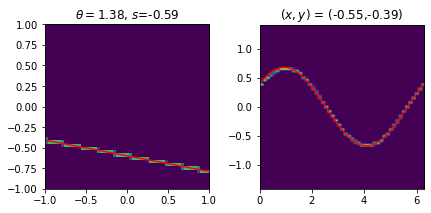

In [118]:
# paramters
n = 51
A, x, s, theta = Radon(n)

# grids
h = 2/n
m = len(s)
L = s[-1]

# sanity check
i = 11
j = 21
ix = 11
iy = 15

I = i*m + j
J = ix*n + iy

thetai = theta[i]
sj = s[j]
xi = x[ix]
yi = x[iy]

u = A[I,:]
f = A[:,J]

# plot
fig, ax = plt.subplots(1,2)

t = np.linspace(-2,2,100)

ax[0].imshow(u.reshape(n,n),extent=[-1,1,-1,1],origin='lower',vmin=0,vmax=1.5*h)
ax[0].plot(t*np.sin(thetai)+sj*np.cos(thetai),-t*np.cos(thetai)+sj*np.sin(thetai),'r')
ax[0].set_title(r'$\theta=$%1.2f, $s$=%1.2f'%(thetai,sj))
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])

ax[1].imshow(f.reshape(n,m).T,extent=(theta[0],theta[-1],-L,L))
ax[1].plot(theta,-xi*np.sin(theta) - yi*np.cos(theta),'r')
ax[1].set_title(r'$(x,y)$ = (%1.2f,%1.2f)'%(xi,yi))
ax[1].set_aspect(np.pi*L/2)

fig.tight_layout()

# Complexity of filling matrix

In [119]:
# timing (expect O(N^3))
N = np.array([8, 16,32,64,128])
T = np.zeros(len(N))
for i in range(len(N)):
    n = N[i]
    t0 = perf_counter()
    A, x, s, theta = Radon(n)
    t1 = perf_counter()
    T[i] = t1-t0
    print(N[i],T[i])

8 0.039736823999191984
16 0.22002114699898812
32 1.5016994289999275
64 11.532120997000675
128 88.26906697499908


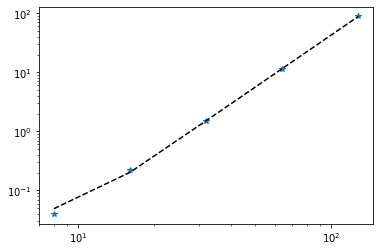

In [120]:
c = np.linalg.pinv(np.array([0*N+1,N,N**2,N**3]).T)@T
plt.loglog(N,T,'*',N,np.array([0*N+1,N,N**2,N**3]).T.dot(c),'k--')

# adjoint-test of matrix-free mat-vecs

In [127]:
n = 21
u1 = np.random.randn(n*n)
f1 = Radon_forward(n,u1)
u2 = Radon_adjoint(n,f1)

print(u1.dot(u2)/f1.dot(f1))


1.0


# complexity of matrix-free mat-vecs

In [130]:
# timing (expect O(N^3))
N = np.array([8, 16,32,64,128])
T = np.zeros(len(N))
for i in range(len(N)):
    n = N[i]
    t0 = perf_counter()
    u1 = np.random.randn(n*n)
    f1 = Radon_forward(n,u1)
    u2 = Radon_adjoint(n,f1)
    t1 = perf_counter()
    T[i] = t1-t0
    print(N[i],T[i])

8 0.0824398860004294
16 0.4394061460006924
32 3.0070554920002905
64 22.84609557300064
128 178.20205772400004


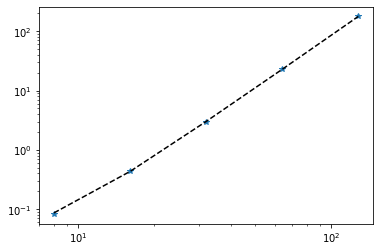

In [131]:
c = np.linalg.pinv(np.array([0*N+1,N,N**2,N**3]).T)@T
plt.loglog(N,T,'*',N,np.array([0*N+1,N,N**2,N**3]).T.dot(c),'k--')